# Intel Image Classification

In this Project, we will show you how to build the basic model in Tensorflow Keras. First of all we will use Convolutional Neural Network (CNN) in this kernel to predict upto 6 class labels.

First, import the important libraries.

In [1]:
from tensorflow import keras
from tensorflow.keras import layers as Layers
from tensorflow.keras import activations as Actications
from tensorflow.keras import models as Models
from tensorflow.keras import optimizers as Optimizer
from tensorflow.keras import metrics as Metrics
from tensorflow.keras import utils as Utils
from tensorflow.keras.utils import model_to_dot
import os
import matplotlib.pyplot as plot
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec

## Data Preprocessing
Now, We need to prepare our data to feed into the model. There is a builtin method in [Keras](https://keras.io/preprocessing/image/) that can extract your images from folders. But, I recommend you to make your own function for this purpose so you can practice the python.

Following is the gernalized function used to extract data from the directory.

In [2]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'glacier': #Folder contain Glacier Images get the '2' class label.
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
            label = 3
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(150,150)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

In [3]:
Images, Labels = get_images('seg_train/') #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)

Lets find shape of our traing data.

As you see, The Training data is in shape of (Number of Training Images, Width of image, Height of image, Channel of image). This shape is very important. If you didnot resize the images to same size. It should be (No. of images,) shape. So, using this shape you cant feed the images to the model.

In [4]:
print("Shape of Images:",Images.shape)
print("Shape of Labels:",Labels.shape)

Shape of Images: (3443, 150, 150, 3)
Shape of Labels: (3443,)


Let us look some random images of our dataset.

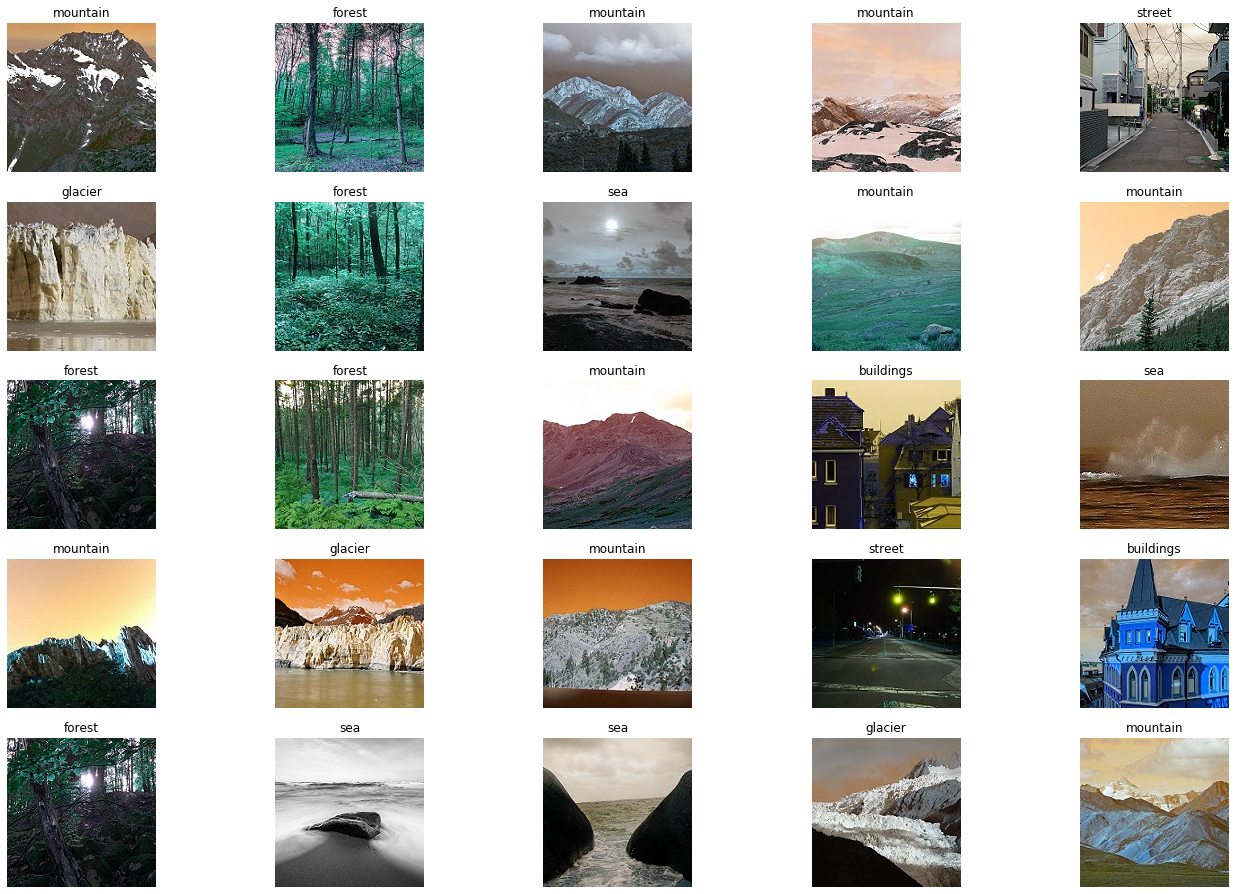

In [5]:
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

Now, Create the CNN model to predict the class labels.This is the basic CNN model.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 180)     324180    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 180)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 180)       291780    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 140)       226940    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 23, 100)       126100    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 50)        4

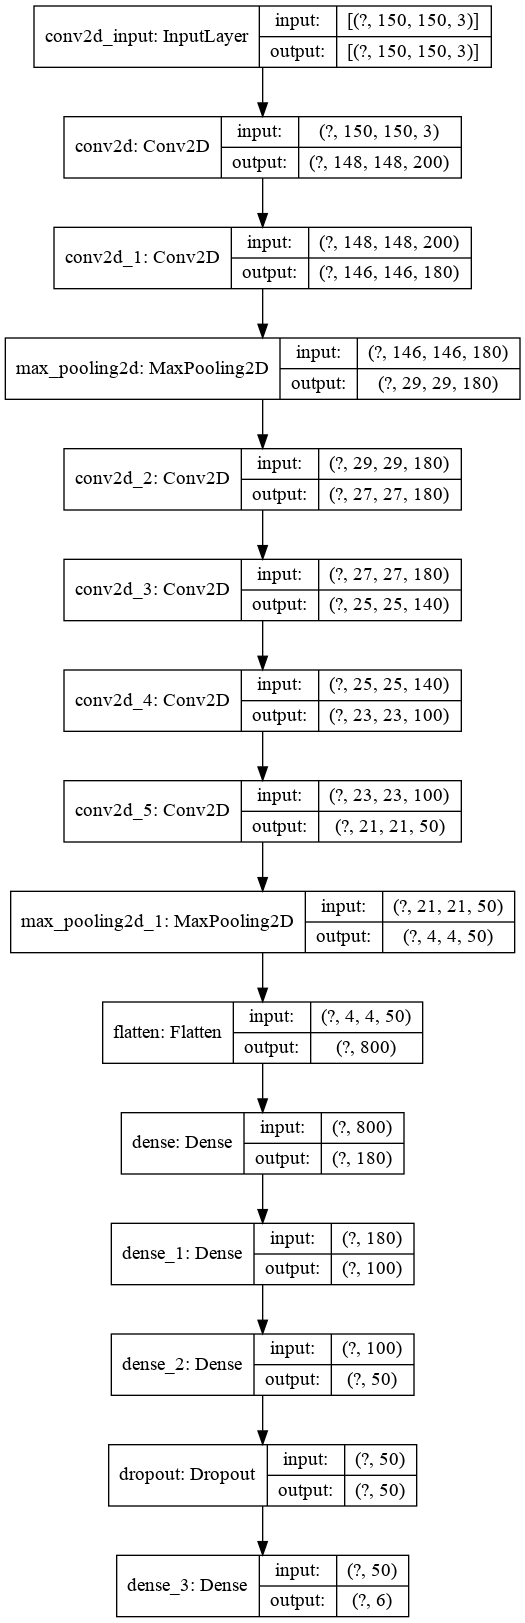

In [6]:
model = Models.Sequential()

model.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Flatten())
model.add(Layers.Dense(180,activation='relu'))
model.add(Layers.Dense(100,activation='relu'))
model.add(Layers.Dense(50,activation='relu'))
model.add(Layers.Dropout(rate=0.5))
model.add(Layers.Dense(6,activation='softmax'))

model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()
# SVG(model_to_dot(model))
# Utils.plot_model(model,to_file='model.png',show_shapes=True)
Utils.plot_model(model, show_shapes=True)

Now, lets train the model with validation split equal to 30% from training data. Validation split is used to determine that our model is not geting over-fitted.

In [7]:
trained = model.fit(Images,Labels,epochs=35,validation_split=0.30)

Epoch 1/35
 3/76 [>.............................] - ETA: 15:46 - loss: 9.0745 - accuracy: 0.1667 

KeyboardInterrupt: 

In [ ]:
plot.plot(trained.history['acc'])
plot.plot(trained.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

To evaluate a model, there are many methods are proposed to evaluate the model. I use Accuracy to evaluate the performance of my model.

In [ ]:
test_images,test_labels = get_images('../input/seg_test/seg_test/')
test_images = np.array(test_images)
test_labels = np.array(test_labels)
model.evaluate(test_images,test_labels, verbose=1)

Lets predict the images from the "pred" folder.

In [ ]:
pred_images,no_labels = get_images('../input/seg_pred/')
pred_images = np.array(pred_images)
pred_images.shape

Following image shows the predicted class label on top of the image and probabilities below of the image.

In [ ]:
fig = plot.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_class = get_classlabel(model.predict_classes(pred_image)[0])
    pred_prob = model.predict(pred_image).reshape(6)
    for j in range(2):
        if (j%2) == 0:
            ax = plot.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plot.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)


fig.show()

I hope you like my kernel. Feel free to ask any question in the comment section. I am looking forward for your **sugestions**!